In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
from scipy import stats
from numpy import median
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import mean_squared_log_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.decomposition import PCA

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [1]:
df_train = pd.read_csv('train.csv')
df_train = df_train.drop(['atemp', 'casual', 'registered', 'windspeed'], axis=1)

# rename some columns
df_train.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

# change some int values to categorical ones
df_train['season'] = df_train.season.astype('category')
df_train['year'] = df_train.year.astype('category')
df_train['month'] = df_train.month.astype('category')
df_train['hour'] = df_train.hour.astype('category')
df_train['holiday'] = df_train.holiday.astype('category')
df_train['weekday'] = df_train.weekday.astype('category')
df_train['workingday'] = df_train.workingday.astype('category')
df_train['weather'] = df_train.weather.astype('category')

df_train['weather'] = df_train['weather'].replace(4,3)
df_train = pd.get_dummies(df_train)
df_train = df_train.drop(df_train[['weather_4']], axis = 1)
df_train

NameError: name 'pd' is not defined

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 64)                3776      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 33        
Total params: 5,889
Trainable params: 5,889
Non-trainable params: 0
_________________________________________________________________

Epoch: 0, loss:3.1478,  root_mean_squared_log_error:1.6403,  val_loss:1.4345,  val_root_mean_squared_log_error:1.1957

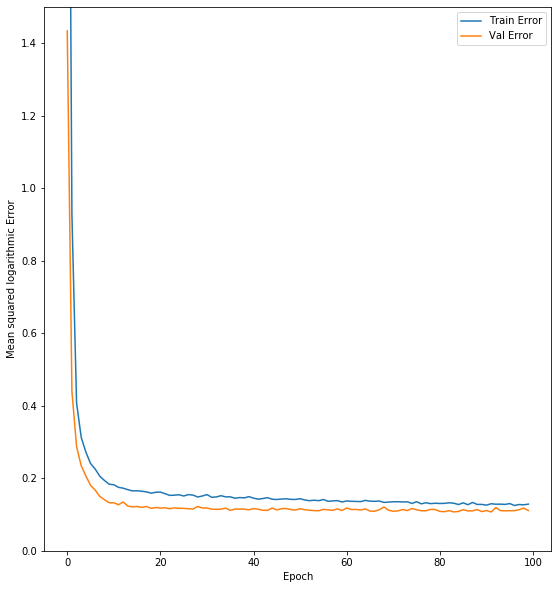

In [35]:
X = df_train.drop(df_train[['count']], axis = 1)
y = df_train['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X = X.to_numpy()
y = y.to_numpy()

X_train = X_train.to_numpy()
y_train = y_train.to_numpy()

X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

#def root_mean_squared_log_error(y_true, y_pred):
##    return tf.keras.losses.MeanSquaredLogarithmicError(y_pred)
#    return keras.backend.mean(y_pred)
##np.sqrt(mean_squared_log_error(y_pred)

K = keras.backend
def root_mean_squared_log_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(K.log(1 + y_pred) - K.log(1 + y_true)))) 


def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', input_shape=[X.shape[1]]),
        layers.Dropout(0.2),
        layers.Dense(32, activation='relu'),
        layers.Dropout(0.4),
#        layers.Dense(16, activation='relu'),
#        layers.Dropout(0.05),
        layers.Dense(1)
    ])

#    optimizer = tf.keras.optimizers.RMSprop(0.001)
    optimizer = keras.optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad = False)
    model.compile(loss = tf.keras.losses.MeanSquaredLogarithmicError(),
                  optimizer=optimizer,
                  metrics=[root_mean_squared_log_error])
    return model


model = build_model()
model.summary()

num_epochs = 100
history = model.fit(X, y, epochs=num_epochs, validation_split=0.22,batch_size=128, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])
#history = model.fit(X_train, y_train, epochs=num_epochs, validation_data = (X_test, y_test), batch_size=128, verbose=0, callbacks=[tfdocs.modeling.EpochDots()])


####### Cros VAlidation #########
#from sklearn.model_selection import KFold
#
#skf = KFold(n_splits=5)
#
#num_epochs = 1000
#all_scores = []
#
#for i, (train_indx, test_indx) in enumerate(skf.split(X_train, y_train)):
#    print(f'Processing fold: {i+1}')
#    partial_train_data = X_train[train_indx]
#    partial_train_targets = y_train[train_indx]
#    partial_val_data = X_train[test_indx]
#    partial_val_targets = y_train[test_indx]
#    model = build_model()
#    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=20000, verbose=0)
#    val_mse, val_mae = model.evaluate(partial_val_data, partial_val_targets, verbose=0)
#    all_scores.append(val_mae)
#
#print(all_scores)
#print(np.mean(all_scores))


##### to do : FIX PLOT ERROR ####

#plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
#plotter.plot({'Error': history}, metric = "val_loss")
#plt.ylim([0, 10])
#_ = plt.y_test('MAE [MPG]')
#
#
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean squared logarithmic Error')
    plt.plot(hist['epoch'], hist['loss'],
             label='Train Error')
    plt.plot(hist['epoch'], hist['val_loss'],
             label = 'Val Error')
    plt.ylim([0,1.5])
    plt.legend()
    
    plt.show()

plot_history(history)

In [32]:
hist = pd.DataFrame(history.history)
hist

y_pred = model.predict(X_test)

for i, y  in enumerate(y_pred):
        if y_pred[i] < 0:
            y_pred[i] = 0
            
print('RMSLE:', np.sqrt(mean_squared_log_error(y_test, y_pred)))
print('R2:', r2_score(y_test, y_pred))

RMSLE: 0.3381307265274233
R2: 0.9206363606285188


In [36]:
##################### Submission Data #######################

filename = 'test.csv' 
df_test = pd.read_csv(filename)

df_test.rename(columns={'weathersit':'weather',
                     'mnth':'month',
                     'hr':'hour',
                     'yr':'year',
                     'hum': 'humidity',
                     'cnt':'count'},inplace=True)

df_test['season'] = df_test.season.astype('category')
df_test['year'] = df_test.year.astype('category')
df_test['month'] = df_test.month.astype('category')
df_test['hour'] = df_test.hour.astype('category')
df_test['holiday'] = df_test.holiday.astype('category')
df_test['weekday'] = df_test.weekday.astype('category')
df_test['workingday'] = df_test.workingday.astype('category')
df_test['weather'] = df_test.weather.astype('category')

df_test = df_test.drop(['atemp', 'windspeed'], axis=1)
df_test = pd.get_dummies(df_test)

test_results = model.predict(df_test).flatten()

for i, y  in enumerate(test_results):
        if test_results[i] < 0:
            test_results[i] = 0

submission = pd.DataFrame()
submission["Id"] = range(test_results.shape[0])
submission["Predicted"] = test_results
submission.to_csv("submission_neuronet.csv", index=False)